In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 33.7 MB/s eta 0:00:00


mecab, kkoran, sentencepiece bpe, sentencepiece unigram

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.18.0
2.0.2
0.6.0


In [ ]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('ratings_train.txt', sep='\t')
test = pd.read_csv('ratings_test.txt', sep='\t')

In [ ]:
stopword= pd.read_csv('stopwords-ko.txt', names=['stopword'], header=None)

In [ ]:
stop_word=stopword['stopword'].to_list()

1. http 링크 제거
2. 영어? A급 B급 C급 -> 우수, 평타, 최악  / 동의어 다의어 표현 피함
3. -_-, -.- -> 지루 , ^-^ -> 행복 으로 교체
4. 1점 2점.. -> 일점, 이점 .. 십점 / 1개 2개... -> 한개 두개 세개 네개 ..열개 / 1위 2위... -> 일위 이위 삼위 ... /  이외 숫자 제거
4. 이모지 - 하트 ♥ -> 최고
5. .., ..., .... -> ...  / ~ ! ? 이 3개 특수기호 중복을 하나로 줄이고 나머지 특수기호 다 제거
6. O alphabet 대문자 O 가 연속적으로 표현 되는 것 강한 욕설 씨발 로 교체
7. ㅋㅋ,ㅎㅎ,ㅠㅠ,ㅜㅜ 유지 ㅋㅋㅋ ㅎㅎㅎ ㅠㅠㅠ ㅜㅜㅜ 이런거는 다 2개 짜리로 바꿈
8.
9. 영어 제거
10. 공백 중복된거 공백 하나로 교체
11. 빈 텍스트 np.nan 교체
12. ㄱㅅ, ㄳ -> 감사
13. 반복된 자모문자
15. ㅗ
16. good, great, awesome ->
17. bad, shit
18. 1류, 2류, 3류, 4류, 5류 -> 일류, 이류, 삼류, 사류, 오류
19. ㄵ ㄴㅈ
20. 숫자를 그냥 지워야 되나?
21. 한글자 자모 지우

모델은 bi lstm classify head

띄어쓰기 잘못된 것은 짧은 문장 필터링 할때 걸러내기, 맞춤법 검사기 cost

>,< >ㅁ< , >_<

In [ ]:
train['document'][520]

'그냥 재미가 없어요....ㅠㅠ'

In [ ]:
custom_preprocess(train['document'][520],stop_word)

'그냥 재미가 없어요...<bb>'

In [ ]:
import re
import numpy as np
import emoji


def custom_preprocess(text, stop_words=None):
  # 1. 입력값 string 확인
  if not isinstance(text, str):
      return text

  # 2. http 링크 제거
  text = re.sub(r"(https?://[^\s가-힣]*)|(www\.[^\s가-힣]*)", " ", text)

  text = re.sub(r"g[o]{2,}d+", "good", text, flags=re.IGNORECASE)

  happy_words = [
    "good", "great", "awesome", "amazing", "fantastic", "excellent",
    "wonderful", "fabulous", "nice", "perfect", "superb", "brilliant",
    "love", "loved", "lovely", "enjoyable", "cool", "best", "favorite", "incredible"
  ]

  bad_words = [
    "bad", "awful", "terrible", "horrible", "worst", "shit",
    "sucks", "poor", "hate", "hated", "disgusting", "dreadful",
    "lame", "crappy", "pathetic", "boring", "disappointing",
    "annoying", "stupid", "waste"
  ]

  for word in happy_words:
    text = re.sub(rf"\b{word}\b", "<good>", text, flags=re.IGNORECASE)
    # 부정 단어 → <bad>
  for word in bad_words:
    text = re.sub(rf"\b{word}\b", "<bad>", text, flags=re.IGNORECASE)

  # 3. A급 B급 C급 → 우수 평타 최악
  text = text.replace("A급", "우수").replace("B급", "평타").replace("C급", "최악")

  # 4. -_- → 지루, ^-^ → 행복
  text = text.replace("ㄵ", "지루").replace("ㄴㅈ", "지루")

  profanity_patterns = ["ㅅㅂ", "ㅈㄹ", "ㅇㅈㄹ", "ㅄ", "ㅂㅅ"]
  for word in profanity_patterns:
    # 단어 경계로 감싸서 독립된 단어로만 매칭
    text = re.sub(rf"\b{word}\b", "<profanity>", text)

  for normal_face in ["-.-", "-,-", "-_-","--","- -","=_="]:
    text = text.replace(normal_face, "<NormalToken>")
  for sad_face in ["ㅠ.ㅠ","ㅠㅡㅠ","ㅠ,ㅠ","ㅠ_ㅠ","ㅜ.ㅜ","ㅜㅡㅜ","ㅜ,ㅜ","ㅜ_ㅜ","ㅠ ㅠ","ㅜ ㅜ","ㅠ ㅜ","ㅜ ㅠ"]:
    text = text.replace(sad_face, "<SadToken>")
  # HappyToken
  for happy_face in ["^-^", "^.^", "^,^","^_^","^^","^ ^","> <",">_<",">.<",">ㅁ<"]:
    text = text.replace(happy_face, "<HappyToken>")

  text = re.sub("-"," ", text)

  # 5. 숫자 변환
  num_map = {
    "1점": "일점", "2점": "이점", "3점": "삼점", "4점": "사점", "5점": "오점",
    "6점": "육점", "7점": "칠점", "8점": "팔점", "9점": "구점", "10점": "십점",
    "1개": "한개", "2개": "두개", "3개": "세개", "4개": "네개", "5개": "다섯개",
    "6개": "여섯개", "7개": "일곱개", "8개": "여덟개", "9개": "아홉개", "10개": "열개",
    "1위": "일위", "2위": "이위", "3위": "삼위", "4위": "사위", "5위": "오위",
    "6위": "육위", "7위": "칠위", "8위": "팔위", "9위": "구위", "10위": "십위",
    "1류": "일류", "2류": "이류", "3류": "삼류", "4류": "사류", "5류": "오류", "1등": "일등"
}
  for k, v in num_map.items():
      text = text.replace(k, v)

  # 1. 숫자+빠다+붙는글자 제거
  text = re.sub(r"\d+빠다[가-힣]*", "", text)

  # 2. 2등~5등 제거
  text = re.sub(r"[2-5]등", "", text)

  text = re.sub(r"(ㄱㅅ|ㄳ)", "감사 ", text)

  # 6. ♥ → 최고
  text = text.replace("♥", "최고 ").replace("♡", "최고 ")
  text = emoji.replace_emoji(text, replace=' ')

  # 7. ... 처리
  text = re.sub(r"\.{2,}", "... ", text)

  # 1. ... → <TRIPLE_DOT>로 임시 치환
  text = re.sub(r"\.{3}", "<TRIPLE_DOT>", text)

  # 2. 나머지 . 제거
  text = re.sub(r"\.", " ", text)

  # 3. <TRIPLE_DOT> → ... 복원
  text = text.replace("<TRIPLE_DOT>", "...")

  # 8. ~!?, 연속 → 한 개로
  text = re.sub(r"[~]{2,}", "~", text)
  text = re.sub(r"[!]{2,}", "!", text)
  text = re.sub(r"[?]{2,}", "?", text)

  # 1. !? 또는 ?! 반복 패턴 → <wow>로 보호
  text = re.sub(r"(!\?|!\?)+|(\?!|\?!)+", "<wow>", text)

  # 2. !, ?, ~, <wow> 뒤에 공백 추가
  text = re.sub(r"([!?~]|<wow>)", r"\1 ", text)

  # 3. <wow> 복원
  text = text.replace("<wow>", "!?")

  # 9. O 연속 → 씨발
  text = re.sub(r"\S*O{2,}\S*", "<filter> ", text)

  # 10. ㅋㅋ 이상 → ㅋㅋ
  text = re.sub(r"ㅋ{2,}", "<zz> ", text)
  # ㅎㅎ 이상 → ㅎㅎ
  text = re.sub(r"ㅎ{2,}", "<HappyToken> ", text)
  # ㅠㅠ 이상 → ㅠㅠ
  text = re.sub(r"ㅠ{2,}", "<SadToken> ", text)
  # ㅜㅜ 이상 → ㅜㅜ
  text = re.sub(r"ㅜ{2,}", "<SadToken> ", text)
  text = re.sub(r"(ㅠㅜ|ㅜㅠ)", "<SadToken> ", text)

  text = re.sub(r"ㅗ{2,}", "<hh> ", text)

  text = re.sub(r"([가-힣])\1{2,}", r"\1\1", text)

  text = re.sub(r";+", ";", text)

  # 14. stop_words 제거
  if stop_word:
    for stop in stop_word:
      text = re.sub(rf"\b{stop}\b", "", text)

  # 15. 특수문자 제거 (허용: 한글, 공백, ~!?...)
  num_to_kor = ['영', '일', '이', '삼', '사', '오', '육', '칠', '팔', '구']
  tags = list(dict.fromkeys(re.findall(r'<[^<>]*>', text)))
  for i, tag in enumerate(tags):
    placeholder = f"태그{num_to_kor[i]}태"
    text = text.replace(tag, placeholder)

  text = re.sub(r"[^가-힣 ~!?;\.]", "", text)

  for i, tag in enumerate(tags):
    placeholder = f"태그{num_to_kor[i]}태"
    text = text.replace(placeholder, tag)

  # 16. 공백 여러개 → 하나
  text = re.sub(r"\s+", " ", text).strip()

  # 17. 빈 문자열 → np.nan
  if text == "" or text == " ":
      return np.nan
  if not re.search(r"[가-힣]|<[^<>]+>|^(; ?)+$", text):
    return np.nan

  return text

In [ ]:
special_tokens = [
    "<good>",
    "<bad>",
    "<profanity>",
    "<SadToken>",
    "<HappyToken>",
    "<filter>",
    "<zz>",
    "<hh>",
    "<NormalToken>"
]

In [ ]:
train.dropna(inplace=True)

In [ ]:
train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
train=train[:30000]

In [ ]:
test.dropna(inplace=True)

In [ ]:
test=test[:10000]

In [ ]:
total=pd.concat([train,test],axis=0)

In [ ]:
total['document2']=total['document'].map(custom_preprocess)

In [ ]:
total.to_csv('total2.csv',index=False)

In [ ]:
train=total[:149995].copy()
test=total[149995:].copy()

In [ ]:
train=total[:30000].copy()
test=total[30000:].copy()

In [ ]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [ ]:
train.isnull().sum()

,0
id,0
document,0
label,0
document2,1144


In [ ]:
def select_label(group):
  counts = group.value_counts()
  if len(counts) == 1:
    return counts.index[0]  # label이 하나만 존재 → 그 값 반환
  elif counts[1] > counts[0]:
    return 1  # label 1이 더 많으면 1 반환
  elif counts[1] < counts[0]:
    return 0  # label 0이 더 많으면 0 반환
  else:
    return random.choice([0,1])  # 동점이면 랜덤 선택

# document2 기준으로 groupby 후 label 선택
train_re = train.groupby('document2', as_index=False).agg({'label': select_label})
test_re = test.groupby('document2', as_index=False).agg({'label' : select_label})

In [ ]:
def custom_length(text):
    # 1. ... → 특수 토큰으로 임시 치환
    text = re.sub(r"\.{3}", "TRIPLE_DOT", text)

    # 2. <...> → 특수 토큰으로 임시 치환
    text = re.sub(r"<[^<>]*>", "TAG", text)

    # 3. 특수 토큰 개수 카운트
    num_triple_dot = text.count("TRIPLE_DOT")
    num_tag = text.count("TAG")

    # 4. 임시 토큰 제거 후 나머지 글자 카운트
    text_cleaned = text.replace("TRIPLE_DOT", "").replace("TAG", "")
    length_rest = len(text_cleaned)

    length_no_space = len(text_cleaned.replace(" ", ""))

    if length_no_space == 1:
      length_rest=1

    # 5. 최종 길이 = 특수토큰 개수 + 나머지 글자 개수
    return num_triple_dot + num_tag + length_rest

In [ ]:
train_re['length']=train_re['document2'].apply(lambda x : custom_length(x))
test_re['length']=test_re['document2'].apply(lambda x : custom_length(x))

In [ ]:
def analyze_length(train_re):
    min_len = train_re['length'].min()
    max_len = train_re['length'].max()
    mean_len = int(train_re['length'].mean())

    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", mean_len)

    # 각 길이별 count
    sentence_length = train_re['length'].value_counts().sort_index()

    # 배열 초기화
    sentence_length_arr = np.zeros(max_len, dtype=int)
    for length, count in sentence_length.items():
        sentence_length_arr[length - 1] = count  # index 보정

    # 시각화
    plt.bar(range(1, max_len + 1), sentence_length_arr, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 301
문장의 평균 길이: 32


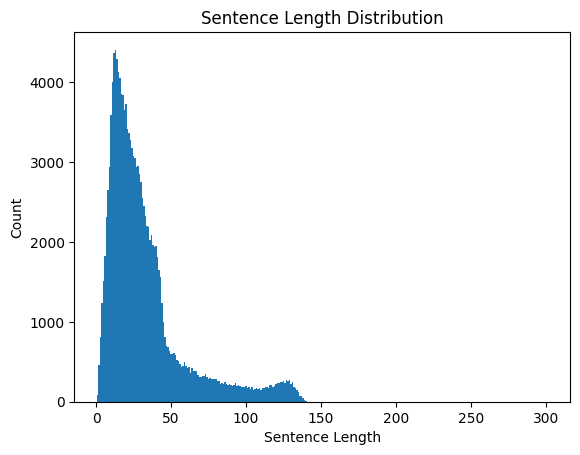

In [ ]:
analyze_length(train_re)

문장의 최단 길이: 1
문장의 최장 길이: 143
문장의 평균 길이: 32


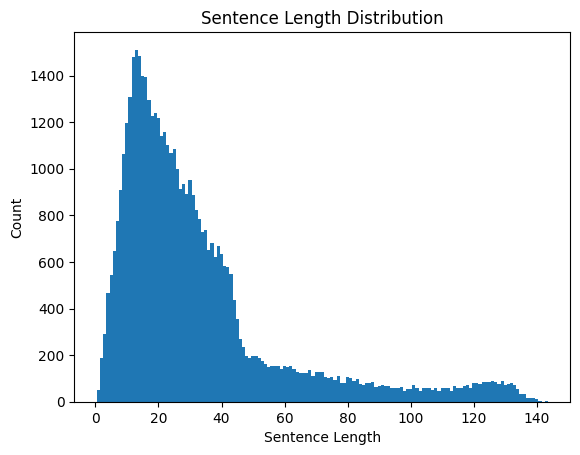

In [ ]:
analyze_length(test_re)

In [ ]:
(train_re['length']>100).sum()/len(train_re)

np.float64(0.0494592004381161)

In [ ]:
max_len=100

In [ ]:
min_len=2

In [ ]:
train_re = train_re[(train_re['length'] >= min_len) & (train_re['length'] <= max_len)].reset_index(drop=True)
test_re = test_re[(test_re['length'] >= min_len) & (test_re['length'] <= max_len)].reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_train_valid_df(df, valid_size=0.2, random_state=42):
    train_df, valid_df = train_test_split(
        df, test_size=valid_size, random_state=random_state, stratify=df['label']
    )
    return train_df, valid_df

In [ ]:
train_df, valid_df = split_train_valid_df(train_re, random_state=42)

In [ ]:
import sentencepiece as spm
import os
temp_file = "./train.temp"

vocab_size = 9000

with open(temp_file, 'w') as f:
    for row in train_df['document2']:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --user_defined_symbols={} --model_type=bpe'.format(
        temp_file,
        vocab_size,
        ','.join(special_tokens)
    )
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

In [ ]:
train_re['document2'][500]

'<zz> 전우치싫어하는 사람 말해라 다 혼줄을 내줄거야'

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds(train_re['document2'][700])
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces(train_re['document2'][700],10, 0.1))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[64, 1459, 7755, 357, 7667, 64]
['▁...', '▁어쩌', '란', '▁말이', '냐', '▁...']
... 어쩌란 말이냐 ...


In [ ]:
def sp_tokenize(s, corpus):
  tensor = []

  for sen in corpus:
      tensor.append(s.EncodeAsIds(sen))

  with open("./korean_spm.vocab", 'r') as f:
      vocab = f.readlines()

  word_index = {}
  index_word = {}

  for idx, line in enumerate(vocab):
      word = line.split("\t")[0]

      word_index.update({word:idx})
      index_word.update({idx:word})

  tensor = [[9000 if token == 0 else token for token in seq] for seq in tensor]

  tensor = tf.keras.preprocessing.sequence.pad_sequences(
  tensor,
  maxlen=max_len,
  padding='post',
  truncating='post'
)

  return tensor, word_index, index_word

In [ ]:
train_tf, sword_index, sindex_word = sp_tokenize(s,train_df['document2'])
valid_tf, _, _ = sp_tokenize(s,valid_df['document2'])
test_tf, _, _ = sp_tokenize(s,test_re['document2'])

In [ ]:
train_tf

array([[ 221,  291,   13, ...,    0,    0,    0],
       [ 184,  719,  172, ...,    0,    0,    0],
       [  13,   45, 1406, ...,    0,    0,    0],
       ...,
       [  13,   38, 3553, ...,    0,    0,    0],
       [1946,  306, 2947, ...,    0,    0,    0],
       [2263,  350,   29, ...,    0,    0,    0]], dtype=int32)

In [ ]:
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_tf,
    train_df['label']
)).shuffle(buffer_size=len(train_df),seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_tf,
    valid_df['label']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_tf, test_re['label'])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW

lr = 5e-4

vocab_size = 9001
embedding_dim = 128
lstm_units = 64

input_ = Input(shape=(None,), name='input')
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(input_)
x = Dropout(0.2)(x)

# x = LSTM(lstm_units, return_sequences=True)(x)
x = LSTM(lstm_units, return_sequences=False)(x)

#x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
#x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)


x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_, outputs=output)

model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_65        │ (None, None, 128) │  1,152,128 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_177         │ (None, None, 128) │          0 │ embedding_65[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_63        │ (None, None)      │          0 │ input[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_85 (LSTM)      │ (None, 64)        │     49,408 │ dropout_177[0][0… │
│                     │                   │            │ not_equal_63[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_178         │ (None, 64)        │          0 │ lstm_85[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_127 (Dense)   │ (None, 64)        │      4,160 │ dropout_178[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_179         │ (None, 64)        │          0 │ dense_127[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 1)         │         65 │ dropout_179[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,205,761 (4.60 MB)

 Trainable params: 1,205,761 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
856/856 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7530 - loss: 0.4952 - val_accuracy: 0.8489 - val_loss: 0.3423 - learning_rate: 5.0000e-04
Epoch 2/20
856/856 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8694 - loss: 0.3120 - val_accuracy: 0.8517 - val_loss: 0.3385 - learning_rate: 5.0000e-04
Epoch 3/20
856/856 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8816 - loss: 0.2769 - val_accuracy: 0.8496 - val_loss: 0.3498 - learning_rate: 5.0000e-04
Epoch 4/20
855/856 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8893 - loss: 0.2545
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
856/856 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8892 - loss: 0.2545 - val_accuracy: 0.8510 - val_loss: 0.3582 - learning_rate: 5.0000e-04
Epoch 5/20
856/856 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9073 - loss: 0.2158 - val_accuracy: 0.8462 - val_loss: 0.4058 - learning_rate: 2.5000e-04
Epoch 5: early stopping
Restoring model weights from the e

In [ ]:
model.evaluate(test_dataset) #vocab 9000

360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8496 - loss: 0.3446


[0.34508010745048523, 0.8510051965713501]

전처리 하나 안하나 85%인거 보면 강한 시그널만 포착하면 되는 이번 task에서 데이터셋 기준 85가 한계느낌.

In [ ]:
model.evaluate(test_dataset) #vocab 12000

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8255 - loss: 0.4003


[0.4085405468940735, 0.8183916211128235]

In [ ]:
model.evaluate(test_dataset) #vocab 7000

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8272 - loss: 0.3942


[0.402022123336792, 0.8198493719100952]

In [ ]:
model.evaluate(test_dataset) #vocab 9000 bpe !?

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8245 - loss: 0.3978


[0.4021438658237457, 0.8228862881660461]

In [ ]:
model.evaluate(test_dataset) #vocab 12000 bpe

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8219 - loss: 0.4051


[0.40881815552711487, 0.8199708461761475]

bpe가 unigram보다 소폭 오름.
gpe 연산이 재현성이 없음.

In [ ]:
sword_index

{'<unk>': 0,
 '<s>': 1,
 '</s>': 2,
 '<good>': 3,
 '<bad>': 4,
 '<profanity>': 5,
 '<SadToken>': 6,
 '<HappyToken>': 7,
 '<filter>': 8,
 '<zz>': 9,
 '<hh>': 10,
 '<NormalToken>': 11,
 '..': 12,
 '...': 13,
 '영화': 14,
 '▁영화': 15,
 '▁이': 16,
 '▁아': 17,
 '▁보': 18,
 '▁재': 19,
 '▁그': 20,
 '▁정': 21,
 '▁나': 22,
 '는데': 23,
 '니다': 24,
 '너무': 25,
 '▁없': 26,
 '▁좋': 27,
 '▁다': 28,
 '▁너무': 29,
 '▁진': 30,
 '▁감': 31,
 '▁재미': 32,
 '▁최': 33,
 '▁연': 34,
 '▁사': 35,
 '▁내': 36,
 '하고': 37,
 '▁지': 38,
 '▁정말': 39,
 '▁어': 40,
 '▁안': 41,
 '▁만': 42,
 '네요': 43,
 '▁한': 44,
 '▁스': 45,
 '▁시': 46,
 '▁가': 47,
 '▁있': 48,
 '으로': 49,
 '▁평': 50,
 '지만': 51,
 '▁봤': 52,
 '▁하': 53,
 '▁기': 54,
 '▁재밌': 55,
 '▁진짜': 56,
 '에서': 57,
 '▁대': 58,
 '▁최고': 59,
 '▁연기': 60,
 '▁마': 61,
 '▁전': 62,
 '▁일': 63,
 '▁잘': 64,
 '▁여': 65,
 '어요': 66,
 '하는': 67,
 '▁수': 68,
 '▁주': 69,
 '▁평점': 70,
 '▁모': 71,
 '▁생': 72,
 '▁...': 73,
 '▁않': 74,
 '▁더': 75,
 '▁개': 76,
 '▁배': 77,
 '드라': 78,
 '▁오': 79,
 '▁제': 80,
 '토리': 81,
 '이다': 82,
 '▁인': 83,
 '드라마': 84,
 

In [ ]:
!pip install mecab-python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 15.6 MB/s eta 0:00:00


In [ ]:
from mecab import MeCab
mecab = MeCab()

In [ ]:
special_tokens

['<good>',
 '<bad>',
 '<profanity>',
 '<SadToken>',
 '<HappyToken>',
 '<filter>',
 '<zz>',
 '<hh>',
 '<NormalToken>']

In [ ]:
special_token_map = {token: str(1000 + i) for i, token in enumerate(special_tokens)}
reverse_token_map = {v: k for k, v in special_token_map.items()}

def preprocess_special_tokens(text, special_token_map):
    for token, num in special_token_map.items():
        text = text.replace(token, num)
    return text

def postprocess_special_tokens(tokens, reverse_token_map):
    return [reverse_token_map.get(token, token) for token in tokens]

def tokenize(text):
    if isinstance(text, str):
        preprocessed_text = preprocess_special_tokens(text, special_token_map)
        tokens = mecab.morphs(preprocessed_text)

        final_tokens = postprocess_special_tokens(tokens, reverse_token_map)

        return final_tokens
    else:
        return []

In [ ]:
def tokenize2(corpus, tokenizer=None, train=True):  # corpus: Tokenized Sentence's List
  if train:
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token='<OOV>')
    tokenizer.fit_on_texts(corpus)

  tensor = tokenizer.texts_to_sequences(corpus)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(
  tensor,
  maxlen=max_len,
  padding='post',
  truncating='post'
)

  return tensor, tokenizer

In [ ]:
def ko_token(df):
  texts=[]
  for i in df['document2']:
    texts.append(tokenize(i))
  return texts

In [ ]:
len(tokenizer.word_index)

17758

In [ ]:
train_list=ko_token(train_df)
valid_list=ko_token(valid_df)
test_list=ko_token(test_re)

In [ ]:
train_tensor, tokenizer = tokenize2(train_list,None,True)
valid_tensor, _ = tokenize2(valid_list,tokenizer,False)
test_tensor, _ = tokenize2(test_list,tokenizer,False)

In [ ]:
BATCH_SIZE = 128

train_dataset2 = tf.data.Dataset.from_tensor_slices((train_tensor,
    train_df['label']
)).shuffle(buffer_size=len(train_df),seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset2 = tf.data.Dataset.from_tensor_slices((valid_tensor,
    valid_df['label']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset2 = tf.data.Dataset.from_tensor_slices((test_tensor, test_re['label'])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW

lr = 3e-4

vocab_size = 17759
embedding_dim = 256
lstm_units = 64

input_ = Input(shape=(None,), name='input')
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(input_)
x = Dropout(0.3)(x)

#x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
#x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
#x = LSTM(lstm_units, return_sequences=True)(x)
x = LSTM(lstm_units, return_sequences=False)(x)

x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=input_, outputs=output)

model2.compile(optimizer=AdamW(learning_rate=lr,weight_decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_64        │ (None, None, 256) │  4,546,304 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_174         │ (None, None, 256) │          0 │ embedding_64[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_62        │ (None, None)      │          0 │ input[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_84 (LSTM)      │ (None, 64)        │     82,176 │ dropout_174[0][0… │
│                     │                   │            │ not_equal_62[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_175         │ (None, 64)        │          0 │ lstm_84[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 64)        │      4,160 │ dropout_175[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_176         │ (None, 64)        │          0 │ dense_125[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_126 (Dense)   │ (None, 1)         │         65 │ dropout_176[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,632,705 (17.67 MB)

 Trainable params: 4,632,705 (17.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [ ]:
history2 = model2.fit(
    train_dataset2,
    validation_data=valid_dataset2,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5904 - loss: 0.6590 - val_accuracy: 0.8160 - val_loss: 0.4142 - learning_rate: 3.0000e-04
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8453 - loss: 0.3779 - val_accuracy: 0.8384 - val_loss: 0.3706 - learning_rate: 3.0000e-04
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8987 - loss: 0.2700 - val_accuracy: 0.8346 - val_loss: 0.3837 - learning_rate: 3.0000e-04
Epoch 4/20
144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9250 - loss: 0.2108
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9249 - loss: 0.2109 - val_accuracy: 0.8324 - val_loss: 0.4066 - learning_rate: 3.0000e-04
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9449 - loss: 0.1653 - val_accuracy: 0.8270 - val_loss: 0.4617 - learning_rate: 1.5000e-04
Epoch 5: early stopping
Restoring model weights from the end of

In [ ]:
model2.evaluate(test_dataset2)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8277 - loss: 0.3814


[0.38503676652908325, 0.8279653191566467]

In [ ]:
model2.evaluate(test_dataset2)

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8347 - loss: 0.3812


[0.3832939565181732, 0.8308586478233337]

In [ ]:
tokenizer.word_index['<OOV>']

1

In [ ]:
valid_oov_count = np.sum(valid_tensor == 1)
test_oov_count = np.sum(test_tensor == 1)

# 전체 token 개수 (option 1: 모든 token 기준)
valid_total_tokens = np.prod(valid_tensor.shape)
test_total_tokens = np.prod(test_tensor.shape)

# 또는 샘플 수 기준으로 정규화 (option 2: 샘플 기준)
valid_sample_count = valid_tensor.shape[0]
test_sample_count = test_tensor.shape[0]

# 비율 계산
valid_oov_ratio = valid_oov_count / valid_total_tokens
test_oov_ratio = test_oov_count / test_total_tokens

valid_oov_per_sample = valid_oov_count / valid_sample_count
test_oov_per_sample = test_oov_count / test_sample_count

print(f"✅ Validation OOV count: {valid_oov_count}")
print(f"✅ Validation OOV ratio (tokens): {valid_oov_ratio:.4f}")
print(f"✅ Validation OOV per sample: {valid_oov_per_sample:.2f}")

print(f"✅ Test OOV count: {test_oov_count}")
print(f"✅ Test OOV ratio (tokens): {test_oov_ratio:.4f}")
print(f"✅ Test OOV per sample: {test_oov_per_sample:.2f}")

✅ Validation OOV count: 2407
✅ Validation OOV ratio (tokens): 0.0049
✅ Validation OOV per sample: 0.49
✅ Test OOV count: 3896
✅ Test OOV ratio (tokens): 0.0047
✅ Test OOV per sample: 0.47


#3.fasttext

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz
!gunzip cc.ko.300.bin.gz

--2025-05-09 05:44:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.70, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4486458164 (4.2G) [application/octet-stream]
Saving to: ‘cc.ko.300.bin.gz’

cc.ko.300.bin.gz    100%[===================>]   4.18G  25.5MB/s    in 5m 43s  

2025-05-09 05:50:28 (12.5 MB/s) - ‘cc.ko.300.bin.gz’ saved [4486458164/4486458164]



In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313505 sha256=cee03c91ec60ae8779ab5c3c88b3fe5e5d0c29478177cd80a8bf6c43638fb792
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import fasttext

# binary 모델 로드
fasttext_model = fasttext.load_model('cc.ko.300.bin')

In [ ]:
vocab_mecab=tokenizer.word_index.keys()

In [ ]:
vocab_tokens = ['<PAD>'] + list(tokenizer.word_index.keys())

In [ ]:
tokenizer.word_index['<OOV>']

1

In [ ]:
embedding_dim = fasttext_model.get_dimension()  # fastText vector dimension
vocab_size = len(vocab_tokens)

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i, token in enumerate(vocab_tokens):
    if token == '<PAD>':
        embedding_matrix[i] = np.zeros(embedding_dim)  # padding은 zero vector
    elif token == '<OOV>':
        embedding_matrix[i] = np.random.normal(0, 1, embedding_dim)  # oov는 random init or 지정
    else:
        embedding_matrix[i] = fasttext_model.get_word_vector(token)

In [ ]:
embedding_matrix.shape

(18015, 300)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

lr = 2e-4

vocab_size = 18015
lstm_units = 64

input_ = Input(shape=(None,), name='input')
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    trainable=True,
    mask_zero=True
)

x = embedding_layer(input_)
x = Dropout(0.2)(x)

# x = LSTM(lstm_units, return_sequences=True)(x)
# x = LSTM(lstm_units, return_sequences=False)(x)

#x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)

x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=input_, outputs=output)

model3.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_48        │ (None, None, 300) │  5,404,500 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_126         │ (None, None, 300) │          0 │ embedding_48[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_46        │ (None, None)      │          0 │ input[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_61    │ (None, 128)       │    186,880 │ dropout_126[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_46[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_127         │ (None, 128)       │          0 │ bidirectional_61… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 128)       │     16,512 │ dropout_127[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_128         │ (None, 128)       │          0 │ dense_93[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 1)         │        129 │ dropout_128[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,608,021 (21.39 MB)

 Trainable params: 5,608,021 (21.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [ ]:
history3 = model3.fit(
    train_dataset2,
    validation_data=valid_dataset2,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6014 - loss: 0.6637 - val_accuracy: 0.7865 - val_loss: 0.4632 - learning_rate: 2.0000e-04
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8086 - loss: 0.4266 - val_accuracy: 0.8224 - val_loss: 0.3957 - learning_rate: 2.0000e-04
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8551 - loss: 0.3479 - val_accuracy: 0.8283 - val_loss: 0.3793 - learning_rate: 2.0000e-04
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8767 - loss: 0.3041 - val_accuracy: 0.8236 - val_loss: 0.3864 - learning_rate: 2.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8932 - loss: 0.2718
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8932 - loss: 0.2717 - val_accuracy: 0.8254 - val_loss: 0.3895 - learning_rate: 2.0000e-04
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy

In [ ]:
model3.evaluate(test_dataset2) # embedding trainable false

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7713 - loss: 0.4761


[0.47900551557540894, 0.7685859799385071]

In [ ]:
model3.evaluate(test_dataset2) # embedding trainable true, 성능차이 크지 않음

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8248 - loss: 0.3883


[0.3947245478630066, 0.8219144940376282]